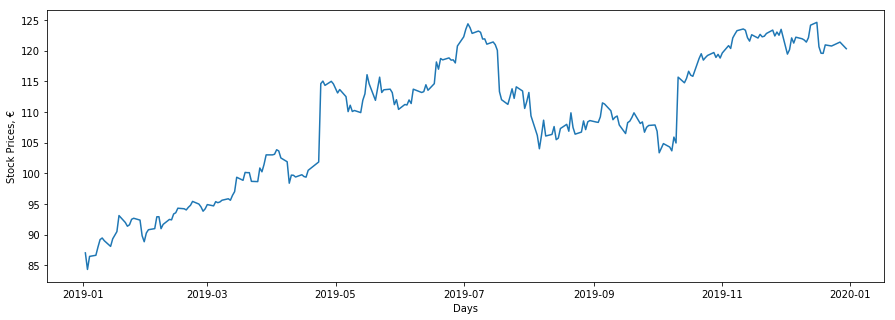

In [3]:
#importing SAP data from FSE
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot of SAP
# stock prices since beginning of 2019 (up to July)

#Change here the code for a different stock ("FSE/SAP_X")
prices = quandl.get("FSE/SAP_X", 
                authtoken="bxu7nmGXAGZH4AWi1kW7", 
                start_date = '2019-01-01', end_date = '2019-12-31'
                ).reset_index(drop = False)[['Date', 'Close']]
                
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()
#prices.tail()


0.0014298989957165376 0.01618979778772199


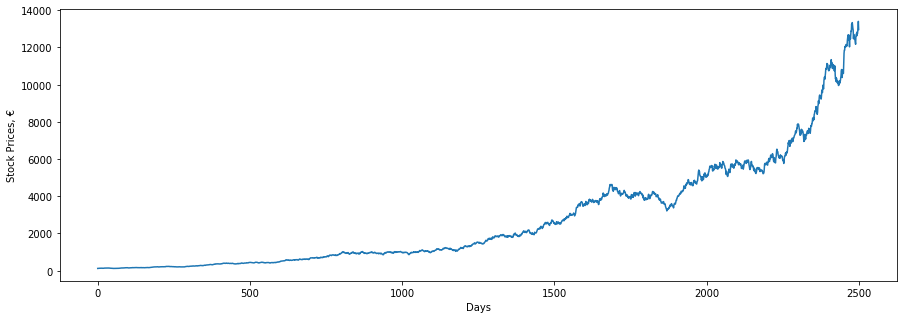

In [6]:
##Simulating the stock prices using GBM

#Set the simulation size here
sim_size = 2500

#Simulation Procedure
#Assuming that Stock price to be the last price of the given data (i.e. on 2019-12-30)
close = prices['Close']
mu = close.pct_change().iloc[0:250].mean()
sigma = close.pct_change().iloc[0:250].std()
print(mu,sigma)
simulation = np.zeros((sim_size,1))
time=np.zeros((sim_size,1))
time[0] = 0
simulation[0] = close[249]

for day in range(1,sim_size):
    time[day]=day
    ins = mu - ((sigma**2)/2) + sigma*np.random.normal()
    term = np.exp(ins)
    simulation[day] = simulation[day-1]*term

#Simulated Data Plot
plt.figure(figsize = (15, 5))
plt.plot(time,simulation)
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

In [7]:
#creating dataset for ML modelling
df = pd.DataFrame(time)
df['close'] = simulation
df.columns = ['t','close']
new_col = np.where(df.close >= df.close.shift(1), 1, 0)  
new_col = new_col[1:]
new_df = df.iloc[:sim_size-1]
new_df['target'] = new_col

#normalising dataset
training_set = new_df.iloc[:, 1:2].values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

/home/pawanagr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[5.90833839e-05],
       [2.37858304e-04],
       [4.22841519e-04],
       ...,
       [9.59675479e-01],
       [9.73337705e-01],
       [1.00000000e+00]])

In [8]:
#creating training dataset and split training-testing
x_train = []
y_train = []
timestamp = 60
length = len(training_set)
for i in range(timestamp, length):
    x_train.append(training_set_scaled[i-timestamp:i, 0])
    y_train.append(np.where(training_set_scaled[i, 0]>=training_set_scaled[i-1, 0],1,0))
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

df_x = x_train
df_y = y_train

train_size = int(len(df_x) * 0.70)
x_train, x_test = df_x[0:train_size], df_x[train_size:len(df_x)]
y_train, y_test = df_y[0:train_size], df_y[train_size:len(df_y)]

print('Observations: %d' % (len(df_x)))
print('Training Observations of X: %d' % (len(x_train)))
print('Testing Observations of X: %d' % (len(x_test)))
print('Training Observations of y: %d' % (len(y_train)))
print('Testing Observations of y: %d' % (len(y_test)))

Observations: 2439
Training Observations of X: 1707
Testing Observations of X: 732
Training Observations of y: 1707
Testing Observations of y: 732


In [33]:
#Model Setup
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GRU, Bidirectional, Dropout
from keras.utils import plot_model

model = Sequential()
535
model.add(LSTM(units = 32, return_sequences = True, input_shape = (x_train.shape[1], 1)))
# #model.add(LSTM(units = 10,return_sequences=False))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model = Sequential()
# model.add(Conv1D(16, 4, activation='relu', input_shape=(self.window,1), padding="same", strides=1))

# model.add(GRU(64, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
model.add(GRU(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='mse', optimizer='adam')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 60, 32)            4352      
_________________________________________________________________
gru_13 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 11,137
Trainable params: 11,137
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
#Training and Evaluation
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=10)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Train on 1707 samples, validate on 732 samples
Epoch 1/100
1707/1707 [==============================] - 17s 10ms/step - loss: 0.6908 - acc: 0.5460 - val_loss: 0.6954 - val_acc: 0.5096
Epoch 2/100
1707/1707 [==============================] - 17s 10ms/step - loss: 0.6896 - acc: 0.5530 - val_loss: 0.6954 - val_acc: 0.5096
Epoch 3/100
1707/1707 [==============================] - 16s 10ms/step - loss: 0.6886 - acc: 0.5536 - val_loss: 0.6965 - val_acc: 0.5096
Epoch 4/100
1707/1707 [==============================] - 16s 10ms/step - loss: 0.6889 - acc: 0.5536 - val_loss: 0.6956 - val_acc: 0.5096
Epoch 5/100
1707/1707 [==============================] - 16s 10ms/step - loss: 0.6877 - acc: 0.5536 - val_loss: 0.6949 - val_acc: 0.5096
Epoch 6/100
1707/1707 [==============================] - 16s 10ms/step - loss: 0.6875 - acc: 0.5536 - val_loss: 0.6981 - val_acc: 0.5096
Epoch 7/100
1707/1707 [==============================] - 16s 10ms/step - loss: 0.6889 - acc: 0.5536 - val_loss: 0.6943 - val_acc: 0

KeyboardInterrupt: 

In [ ]:
#Reference

# 'https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18'
# 'https://blog.quantinsti.com/random-walk-geometric-brownian-motion/#'
# 'https://www.kaggle.com/pankul/lstm-stock-price-movement-prediction'
# 'https://machinelearningmastery.com/keras-functional-api-deep-learning/'